# 1. Data Cleaning

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.stats.stattools

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

In [111]:
df = pd.read_csv('data/kc_house_data.csv')
#df.info()

# Converting column dtypes

In [112]:
# converting date column from str to int
df['date'] = pd.to_datetime(df['date']).dt.year
#df.info()

In [113]:
#extracting zip code from address and converting to int
df['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b').astype('str')

In [114]:
 #lambda function to extract the first character of each object and convert it to an int.
extract_num = lambda x: int(x[:2])

# Apply the lambda function
df['grade'] = df['grade'].apply(extract_num)

In [115]:
df['nuisance'] = df['nuisance'].map({'YES': 0, 'NO': 1})
df['greenbelt'] = df['greenbelt'].map({'YES': 1, 'NO': 0})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})

In [135]:
#df['yr_renovated'] = df['yr_renovated'].astype(int)

In [136]:
# 1 is not renovated
df['renovated'] = (df['yr_renovated'] == 0).astype(int)

# Filtering out rows not in King County

In [137]:
#filtering out adresses not in Washington
df_wash = df[df['address'].str.contains('Washington')]
#df_wash.info()

#### URL for King County Coordinate info
[King County Coordinates](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)

In [138]:
df_king = df_wash[(df_wash['lat'] >= 46.71) 
                       & (df['lat'] <= 48.31) 
                       & (df['long'] >= -123.07) 
                       & (df['long'] <= -119.90)]
#df_king.info()

# Dropping Null, Duplicate, and Unecessary Columns

In [139]:
df_king.drop(['id', 'address', 'date', 'view', 'sqft_above', 'sqft_basement', 'lat', 'long'], axis=1, inplace=True)
#df_king.info()

In [140]:
df_king.drop_duplicates(inplace=True)
#df_king.info()

In [141]:
df_king.dropna(inplace=True)
#df_king.info()

# 2. Data Understanding

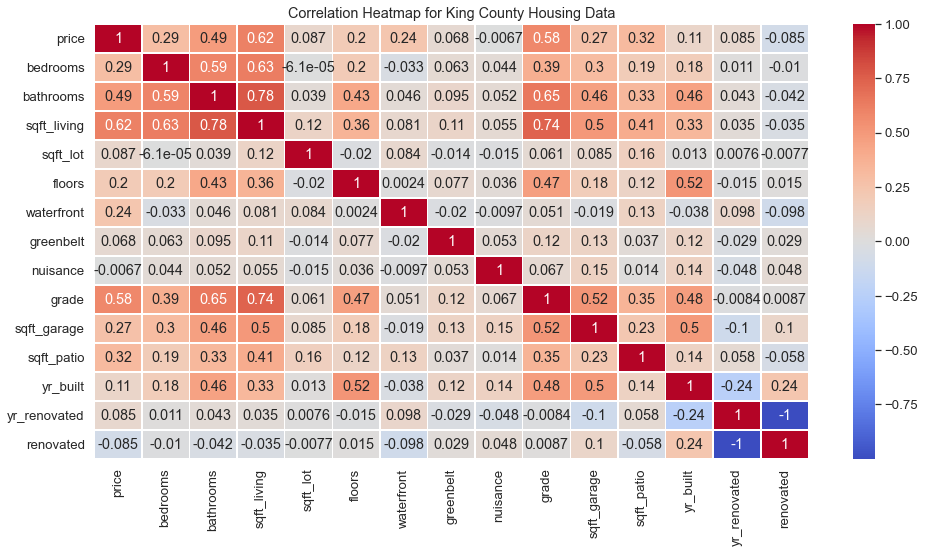

In [142]:
corr_matrix = df_king.corr(method='pearson')

sns.set(font_scale=1.2)
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for King County Housing Data")
plt.show()

# 3. Creating Simple Base Model

### Examining the heatmap, it appears that the Square Feet of Living Space in a home exhibits the strongest correlation coefficient with respect to housing prices. Consequently, using this feature as the basis for a model is logical, as one would intuitively assume that the size of a home, measured in square feet, significantly influences its price.

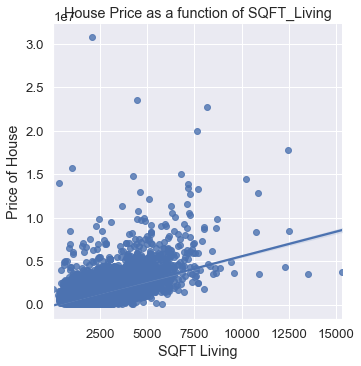

In [143]:
sns.lmplot(data=df_king, x='sqft_living', y='price')
plt.xlabel('SQFT Living')
plt.ylabel('Price of House')
plt.title('House Price as a function of SQFT_Living');

#### Seems to be a clear relationship


In [144]:
#using log to adjust our most correlated feature and price so that we can create a base model with existing outliers
#df_king['log_sqft_living'] = np.log(df_king['sqft_living'])
#df_king['log_price'] = np.log(df_king['price'])

In [236]:
y = df_king['price']
X = df_king['sqft_living']

base_model = sm.OLS(y, sm.add_constant(X)).fit()


print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.789e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:46:47   Log-Likelihood:            -4.3405e+05
No. Observations:               29160   AIC:                         8.681e+05
Df Residuals:                   29158   BIC:                         8.681e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.266e+04   9917.964     -9.342      

#### Assumption Tests and Analysis:
- Passes **multicollinearity** with cond. no. 132 (under 1,000)
- Passes **independence** with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
- Fails **normality** Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
- Slightly skewed left
- 9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

# Assumption Testing 

## I. # Linearity Residual plots

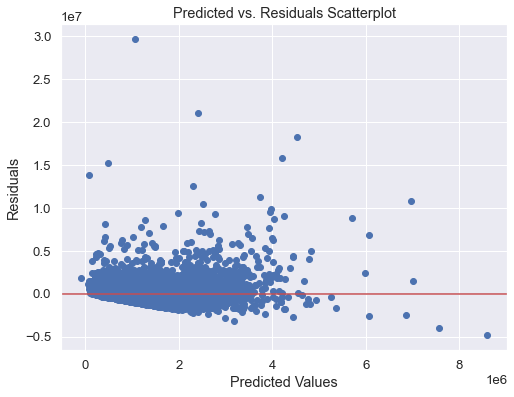

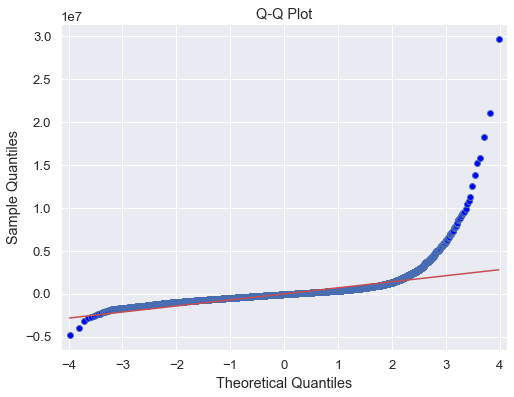

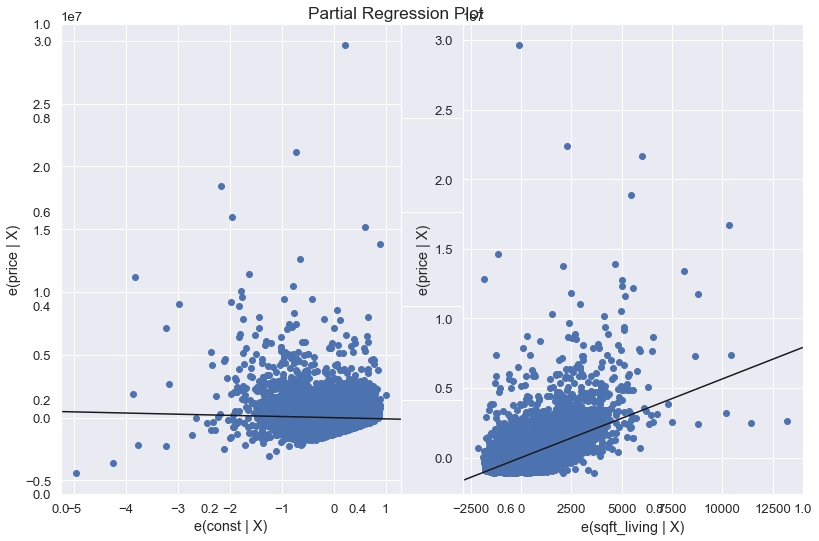

In [237]:
# Residual plots
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(base_model.predict(), base_model.resid)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Predicted vs. Residuals Scatterplot')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

# Partial regression plots
fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.plot_partregress_grid(base_model, fig=fig)
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(base_model)

## Based on our q-q plot and linear rainbow diagnostic we cann assume that our linear regression model has satisfied the Linear Assumptino

## II. **Normality Assumption**: Assumes that residuals or errors are normally distributed.

- The **Omnibus test** is used to detect normality assumption. A low probability value suggests that the distribution of errors or residuals is not normal. In this case, the p-value for the Omnibus test is 0.000 which means that we can reject the null hypothesis of normal distribution of residuals and conclude that the normality assumption is violated.
- **Jarque-Bera** (JB) test is also used to check for normality assumption. The JB test statistic measures whether the data has skewness or kurtosis values matching a normal distribution. If the test statistic is large and/or the p-value is low, then skewness and/or kurtosis are not similar to a normal distribution. With a very large test statistic of 50073454.459 and the p-value of 0.00, we can reject the null hypothesis of normality, indicating a violation of normality assumption.
- **Skewness** measures the degree of asymmetry of a probability distribution. A symmetrical distribution will have a skewness of 0. Positive skewness means there are more observations on the left side of the distribution, while negative means more observations on the right side. Here, the skewness value of 8.237 indicates positive skewness.
- **Kurtosis** measures the degree of peakness of a probability distribution. A normal distribution has a kurtosis of 3, and if it is greater than 3, it is said to be leptokurtic or heavy-tailed, and if it is less than 3, it is said to be platykurtic or light-tailed. The value of Kurtosis here is exceptionally high at 205.252 reflecting a severe deviation from normality.

In [ ]:
base_model.summary().tables[2]

#### with omnibus and Jarque-Bera having small p-values this suggests that we cannot reject the null-hypothesis that the base model data is normally distributed.
#### Also with a Kurtosis greater than 3 this would suggest that the distribution is heavilyt tailed/spread out
#### Therefore this model does not pass normality assumption and we can not assume that this model is normally distributed

## III.Homoscedasticity Assumption: Assumes that the variance of residuals is constant across observations or independent variable values.
- need to look into this

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [ ]:
het_breuschpagan(base_model.resid, sm.add_constant(X))

#### larger p-values for Lagrange Multiplier and Breuschpagan suggest that this base model passes Homoscedasticity Assumption

# IV. Independence

In [ ]:
resids = base_model.resid 
dw = sm.stats.stattools.durbin_watson
dw(resids)

#### A score of almost 2 indicates that there is no autocorrelation and therefore passess the independence assumption

# 4. Testing multiple regression models

## I. One-Hot encoding categorical data to see if any sub category has a stronger correlation with price than current variables (these categorical columns were not on scale like 'grade' and 'condition' and the boolean categories)
#### Categorical columns:
- zipcode
- heat_source
- sewer_system

#### A. Zipcodes

In [238]:
df_dummy_zip = df_king.copy()

In [239]:
# Get unique zipcodes
unique_zipcodes = df_dummy_zip['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip = pd.get_dummies(df_dummy_zip, columns=['zipcode'], prefix='zipcode')

# Create a list of new dummy zipcode columns
zip_col = [f"zipcode_{zipcode}" for zipcode in unique_zipcodes]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated = df_zip[[most_correlated] + zip_col]

In [240]:
#X_iterated.corr()['price'].sort_values(ascending=False).head(10)

In [241]:
zip_dummy_base = X_iterated.drop('zipcode_98042', axis=1)

In [242]:
iterated_model = sm.OLS(y, sm.add_constant(zip_dummy_base))
iterated_results = iterated_model.fit()
print(iterated_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     481.6
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:49:55   Log-Likelihood:            -4.2802e+05
No. Observations:               29160   AIC:                         8.562e+05
Df Residuals:                   29072   BIC:                         8.569e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.221e+05      2e+04    -16.132

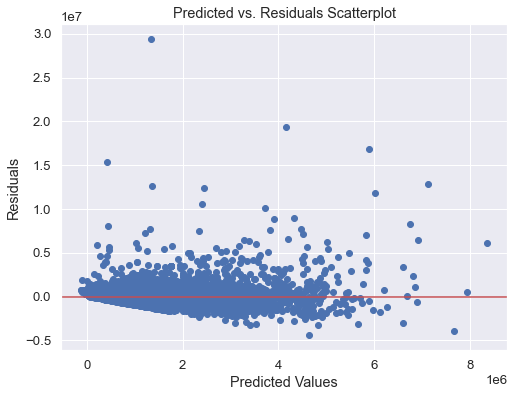

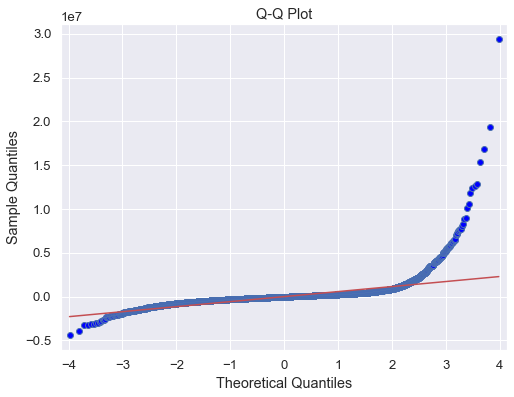

In [243]:
# Residual plots
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(iterated_results.predict(), iterated_results.resid)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Predicted vs. Residuals Scatterplot')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(iterated_results.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

#### B. Heat_Source

In [244]:
df_dummy_heat = df_king.copy()

In [245]:
# Get unique zipcodes
heat_systems = df_dummy_heat['heat_source'].unique()

# Convert column 'zipcode' into dummy columns
df_heat = pd.get_dummies(df_dummy_heat, columns=['heat_source'], prefix='heat_source')

# Create a list of new dummy zipcode columns
heat_col = [f"heat_source_{heat_source}" for heat_source in heat_systems]

# Define the most correlated column
most_correlated2 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated2 = df_heat[[most_correlated2] + heat_col]

In [246]:
df_dummy_heat['heat_source'].value_counts()

Gas                  20159
Electricity           5929
Oil                   2898
Gas/Solar               93
Electricity/Solar       57
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [247]:
X_iterated2.corr()['sqft_living'].sort_values(ascending=False)

sqft_living                      1.000000
heat_source_Gas                  0.264457
heat_source_Gas/Solar            0.031162
heat_source_Oil/Solar           -0.003239
heat_source_Other               -0.005797
heat_source_Electricity/Solar   -0.006666
heat_source_Oil                 -0.151600
heat_source_Electricity         -0.194008
Name: sqft_living, dtype: float64

In [248]:
heat_dum_base = X_iterated2.drop('heat_source_Gas', axis=1)

In [249]:
iterated_model2 = sm.OLS(y, sm.add_constant(heat_dum_base))
iterated_results2 = iterated_model2.fit()
print(iterated_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     2565.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:05   Log-Likelihood:            -4.3403e+05
No. Observations:               29160   AIC:                         8.681e+05
Df Residuals:                   29152   BIC:                         8.681e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

#### C. sewer_system

In [250]:
df_dummy_sewer = df_king.copy()

In [251]:
# Get unique zipcodes
sewer_systems = df_dummy_sewer['sewer_system'].unique()

# Convert column 'zipcode' into dummy columns
df_sewer = pd.get_dummies(df_dummy_sewer, columns=['sewer_system'], prefix='sewer_system')

# Create a list of new dummy zipcode columns
zip_col3 = [f"sewer_system_{sewer_system}" for sewer_system in sewer_systems]

# Define the most correlated column
most_correlated3 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated3 = df_sewer[[most_correlated3] + zip_col3]

In [252]:
df_dummy_sewer['sewer_system'].value_counts()

PUBLIC                24820
PRIVATE                4333
PRIVATE RESTRICTED        5
PUBLIC RESTRICTED         2
Name: sewer_system, dtype: int64

In [253]:
X_iterated3.corr()['sqft_living'].sort_values(ascending=False)

sqft_living                        1.000000
sewer_system_PRIVATE               0.054976
sewer_system_PUBLIC RESTRICTED     0.002946
sewer_system_PRIVATE RESTRICTED   -0.009661
sewer_system_PUBLIC               -0.054653
Name: sqft_living, dtype: float64

In [254]:
sewer_dum_base = X_iterated3.drop('sewer_system_PUBLIC', axis=1)

In [255]:
iterated_model3 = sm.OLS(y, sm.add_constant(sewer_dum_base))
iterated_results3 = iterated_model3.fit()
print(iterated_results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     4535.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:07   Log-Likelihood:            -4.3398e+05
No. Observations:               29160   AIC:                         8.680e+05
Df Residuals:                   29155   BIC:                         8.680e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Assumption Tests and Analysis:
Fails multicollinearity with cond. no. higher than 1000 (may be able to pass after removing outliers)
Passes independence with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
Fails normality Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
Slightly skewed left
9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

#### D. condition

In [256]:
df_dummy_condtion = df_king.copy()

In [257]:
# Get unique zipcodes
conditions = df_dummy_condtion['condition'].unique()

# Convert column 'zipcode' into dummy columns
df_con = pd.get_dummies(df_dummy_condtion, columns=['condition'], prefix='condition')

# Create a list of new dummy zipcode columns
con_col = [f"condition_{condition}" for condition in conditions]

# Define the most correlated column
most_correlated4 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated4 = df_con[[most_correlated4] + con_col]

In [258]:
con_dum_base = X_iterated4.drop('condition_Average', axis=1)

In [259]:
iterated_model4 = sm.OLS(y, sm.add_constant(con_dum_base))
iterated_results4 = iterated_model4.fit()

In [260]:
print(iterated_results4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     3595.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:09   Log-Likelihood:            -4.3403e+05
No. Observations:               29160   AIC:                         8.681e+05
Df Residuals:                   29154   BIC:                         8.681e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.167e+05   1

#### E. grade

In [261]:
df_dummy_grad = df_king.copy()

In [262]:
# Get unique zipcodes
grades = df_dummy_grad['grade'].unique()

# Convert column 'zipcode' into dummy columns
df_grade = pd.get_dummies(df_dummy_grad, columns=['grade'], prefix='grade')

# Create a list of new dummy zipcode columns
grade_col = [f"grade_{grade}" for grade in grades]

# Define the most correlated column
most_correlated5 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated5 = df_grade[[most_correlated5] + grade_col]

In [263]:
grade_dum_base = X_iterated5.drop('grade_7', axis=1)

In [264]:
iterated_model5 = sm.OLS(y, sm.add_constant(grade_dum_base))
iterated_results5 = iterated_model5.fit()

In [265]:
print(iterated_results5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     2176.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:10   Log-Likelihood:            -4.3170e+05
No. Observations:               29160   AIC:                         8.634e+05
Df Residuals:                   29147   BIC:                         8.635e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.821e+05   1.19e+04     23.613      

#### F. yr_renovated

In [266]:
df_dummy_ren = df_king.copy()

In [267]:
df_dummy_ren['yr_renovated'].value_counts()

0       27792
2021       69
2006       49
2018       44
1990       42
        ...  
1924        1
1972        1
1948        1
1942        1
1966        1
Name: yr_renovated, Length: 82, dtype: int64

In [268]:
# Get unique zipcodes
renovations = df_dummy_ren['yr_renovated'].unique()

# Convert column 'zipcode' into dummy columns
df_ren = pd.get_dummies(df_dummy_ren, columns=['yr_renovated'], prefix='yr_renovated')

# Create a list of new dummy zipcode columns
ren_col = [f"yr_renovated_{yr_renovated}" for yr_renovated in renovations]

# Define the most correlated column
most_correlated6 = 'log_sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated6 = df_ren[[most_correlated5] + ren_col]

In [269]:
grade_dum_base = X_iterated6.drop('yr_renovated_2021', axis=1)

In [270]:
iterated_model6 = sm.OLS(y, sm.add_constant(grade_dum_base))
iterated_results6 = iterated_model6.fit()
print(iterated_results6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     225.1
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:11   Log-Likelihood:            -4.3386e+05
No. Observations:               29160   AIC:                         8.679e+05
Df Residuals:                   29077   BIC:                         8.686e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -5.448e+04   8.48e+0

## Checking boolean features

In [271]:
columns = ['sqft_living', 'waterfront']

y = df_king['price']
X = df_king[columns]

water_model = sm.OLS(y, sm.add_constant(X)).fit()


print(water_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 1.041e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:12   Log-Likelihood:            -4.3317e+05
No. Observations:               29160   AIC:                         8.664e+05
Df Residuals:                   29157   BIC:                         8.664e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.531e+04   9624.689     -8.864      

In [272]:
columns2 = ['sqft_living', 'greenbelt']

y = df_king['price']
X = df_king[columns2]

green_model = sm.OLS(y, sm.add_constant(X)).fit()


print(green_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     8946.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:12   Log-Likelihood:            -4.3405e+05
No. Observations:               29160   AIC:                         8.681e+05
Df Residuals:                   29157   BIC:                         8.681e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.282e+04   9924.319     -9.352      

In [273]:
columns3 = ['sqft_living', 'nuisance']

y = df_king['price']
X = df_king[columns3]

nuisance_model = sm.OLS(y, sm.add_constant(X)).fit()


print(nuisance_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     9010.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:12   Log-Likelihood:            -4.3401e+05
No. Observations:               29160   AIC:                         8.680e+05
Df Residuals:                   29157   BIC:                         8.681e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.635e+04   1.31e+04     -1.247      

In [274]:
columns4 = ['sqft_living', 'renovated']

y = df_king['price']
X = df_king[columns4]

renovation_model = sm.OLS(y, sm.add_constant(X)).fit()


print(renovation_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     9100.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:50:12   Log-Likelihood:            -4.3396e+05
No. Observations:               29160   AIC:                         8.679e+05
Df Residuals:                   29157   BIC:                         8.679e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.685e+05   2.13e+04      7.905      

## Finalizing Model

### Using SQFT Living

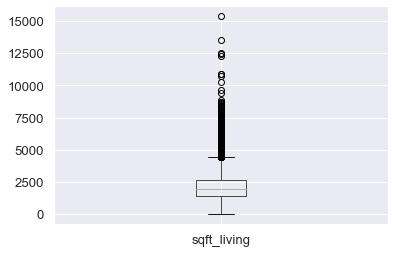

In [275]:
df_king.boxplot(column=['sqft_living'])

plt.show()

In [352]:
#df_king_final = df_king[(df_king['price'] <= 900000)]

In [353]:
#df_king_final.boxplot(column=['price'])

#plt.show()

In [354]:
#df_king_final = df_king[(df_king['renovated'] == 0)]

In [360]:
df_king_final = df_king.copy()

In [361]:
# Get unique zipcodes
unique_zipcodes2 = df_king_final['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip2 = pd.get_dummies(df_king_final, columns=['zipcode'], prefix='zipcode')

# Create a list of new dummy zipcode columns
zip_col2 = [f"zipcode_{zipcode}" for zipcode in unique_zipcodes2]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated_final = df_zip2[[most_correlated] + ['price'] +  zip_col2 + ['waterfront']]

In [362]:
#zip_dummy_final = X_iterated_final.drop('zipcode_98115', axis=1)

In [363]:
y_final = X_iterated_final['price']
x_final = X_iterated_final.drop('price', axis = 1)
model_final = sm.OLS(y_final, sm.add_constant(x_final)).fit()

In [364]:
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     554.4
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:01:37   Log-Likelihood:            -4.2667e+05
No. Observations:               29160   AIC:                         8.535e+05
Df Residuals:                   29071   BIC:                         8.542e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.54e+05   1.84e+04      8.369

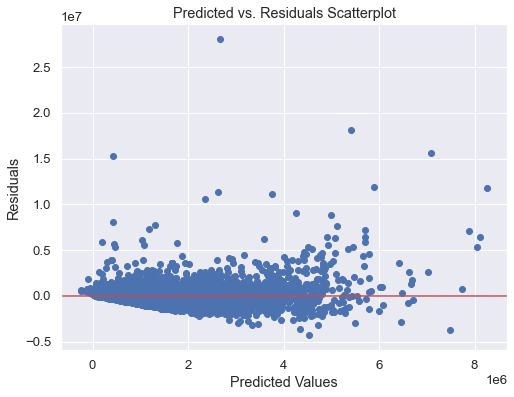

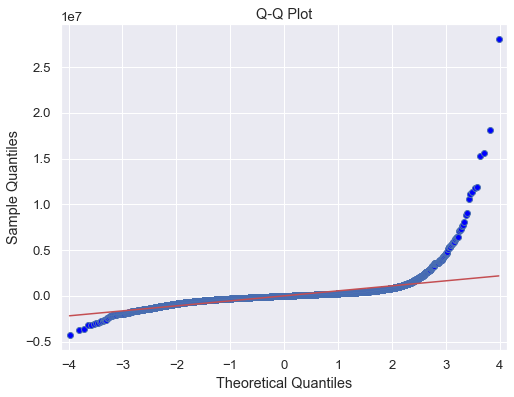

In [366]:
# Residual plots
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(model_final.predict(), model_final.resid)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Predicted vs. Residuals Scatterplot')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_final.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

# Conclusion

Base Model:
- Adjusted R-squared: 0.380
- F-statistic: 1.789e+04
- Prob (F-statistic): 0.00
- Df Model: 1
- Condition Number: 4.01e+05
- Multicollinearity: Might have strong multicollinearity problems

Final Model:
- Adjusted R-squared: 0.625
- F-statistic: 554.4
- Prob (F-statistic): 0.00
- Df Model: 88
- Condition Number: 9.79e+16
- Multicollinearity: Might have strong multicollinearity problems


Final Model is better as it has a higher adjusted R-squared value (0.625 vs. 0.380), indicating that it explains more variation in housing prices. However, both models might have strong multicollinearity problems or numerical issues.